<a href="https://colab.research.google.com/github/Reevoc/Tesi/blob/main/Tumori_DCGAN_35GB_RAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DCGAN

##Libreire 

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import time

from keras import backend
from google.colab import drive
from PIL import Image
from IPython import display
from tensorflow.keras import layers

In [ ]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-_q_cjprq
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-_q_cjprq
ERROR: Operation cancelled by user


##Upload dei dati da Drive

In [ ]:
drive.mount('/content/drive', force_remount = True)

folder_benign_train = '/content/drive/MyDrive/Colab/train/benign'
folder_malignant_train = '/content/drive/MyDrive/Colab/train/malignant'

folder_benign_test = '/content/drive/MyDrive/Colab/test/benign'
folder_malignant_test = '/content/drive/MyDrive/Colab/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert('RGB'))

# Carico le immagini di train
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='float32')
print("train beningi caricati")
#ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
#X_malignant = np.array(ims_malignant, dtype='float32')
#print("train maligni caricati")


Mounted at /content/drive
train beningi caricati
train maligni caricati


#**Normalizzazione dei dati** 
Preparo i dati dati per essere utilizzati 
1.   Faccio un reshape e converto in float32
2.   Nomalizzo i dati affinche siano compresi tra i valori 0 e 1
3.   Creo il dataset aggiungedi la dimensione di batch



In [ ]:
X_benign = X_benign.reshape(X_benign.shape[0], 224, 224, 3).astype('float32')
X_malignant = X_malignant.reshape(X_malignant.shape[0], 224, 224, 3).astype('float32')

print(f'la dimesione =>{X_benign.shape}')
print(f'il numerdo di dimesion =>{X_benign.ndim}') 

X_benign = (X_benign - 127.5) / 127.5 
X_malignant = (X_malignant - 127.5) / 127.5 

# Batch and shuffle the data
BUFFER_SIZE = 40000
BATCH_SIZE = 256
train_benign = tf.data.Dataset.from_tensor_slices(X_benign).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_malignant = tf.data.Dataset.from_tensor_slices(X_malignant).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)



la dimesione =>(1440, 224, 224, 3)
il numerdo di dimesion =>4


#**Generatore** 
Il generatore utilizza Conv2DTranspose per produrre un'immagine da un seme (rumore casuale). Inizia con un livello Dense che prende questo seme come input, quindi sovracampiona più volte fino a raggiungere la dimensione dell'immagine desiderata di 224x224x3.

In [ ]:
def make_generator_model_tensorflow(filter, kernel_size):
    #kernel size (5,5) , filter 1 
    model = tf.keras.Sequential()
    model.add(layers.Dense(56*56*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((56, 56, 256)))
    assert model.output_shape == (None, 56, 56, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 56, 56, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 112, 112, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(filter, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 224, 224, 3)
    model.summary()

    return model

###Test funzionamento generatore
utilizzo il generatore non ancora addestrato per generare un immagine a rumore comletamente casuale

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 802816)            80281600  
_________________________________________________________________
batch_normalization_3 (Batch (None, 802816)            3211264   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 802816)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 56, 56, 256)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 56, 56, 128)       819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 56, 56, 128)       512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 56, 56, 128)      

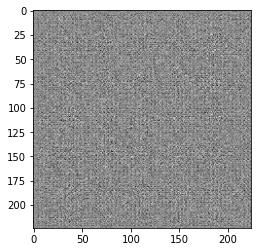

In [ ]:
generator = make_generator_model_tensorflow(3, (5,5))

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

#**Discriminatore**
Il discriminatoreè un semplice modello basato su una CNN che si occuperà di discriminare le immagini false da quelle vere. 
Lobbiettivo della rete gan sarà ingannare il discriminatore creando immagini sempre migliori

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
     input_shape=[224,224,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

###Uso del discriminatore

Usa il discriminatore (non ancora addestrato) per classificare le immagini generate come reali o false. Il modello verrà addestrato per produrre valori positivi per immagini reali e valori negativi per immagini false.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-2.4892075e-05]], shape=(1, 1), dtype=float32)


#Perdita Ottimizzatori 

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#**Ciclo di addestramento** 

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16#per le gif

seed = tf.random.normal([num_examples_to_generate, noise_dim])


Il ciclo di addestramento inizia con il generatore che riceve un seme casuale come input. Quel seme viene utilizzato per produrre un'immagine. Il discriminatore viene quindi utilizzato per classificare immagini reali (tratte dal set di addestramento) e immagini false (prodotte dal generatore). La perdita viene calcolata per ciascuno di questi modelli e i gradienti vengono utilizzati per aggiornare il generatore e il discriminatore.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".

def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  loss_graphic()

In [ ]:
  def loss_graphic()
    fig, ax = plt.subplots()
    plt.plot(gen_loss, label='Generator', alpha=0.5)
    plt.plot( disc_loss, label='Discriminator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()
    plt.savefig('train_losses.png')
    plt.show()
    plt.close()

###Genera e salva immagini


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

###Salva i checkpoint
Salvo i checkpoit, può essere utile nel caso in cui venga interrotta un'attività di addestramento di lunga durata.

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/GansCheckpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#**Addestra il modello**
Chiama il metodo train() definito sopra per addestrare il generatore e il discriminatore simultaneamente. È importante che il generatore e il discriminatore non si superino a vicenda cioè si devono alleare a un ritmo simile.

All'inizio della formazione, le immagini generate sembrano rumori casuali. Con il progredire della formazione, le cifre generate appariranno sempre più reali. Dopo circa 50 epoche generalemte le immagini iniziano ad avere una forma simile a quelle da noi cericate.

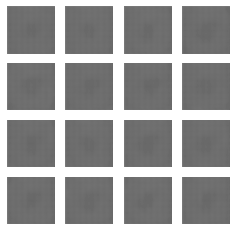

Time for epoch 27 is 170.80341601371765 sec


In [ ]:
train(train_benign, EPOCHS)
del model
del history


In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir, latest_filename = "ckpt"))

#Crea una GIF

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

Usa imageio per creare una gif animata utilizzando le immagini salvate durante l'allenamento.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)